In [56]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

In [57]:
data_dir = r"C:\Users\colew\Desktop\WPI\Classes\Current\CS4341\Projects\AiSign\notebook\data"

In [58]:
class_name = os.listdir(data_dir)
len(class_name)

2

In [59]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms as T,datasets

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:{}".format(device))

Device:cuda


In [61]:
data_transform = T.Compose([
    T.Resize(size=(224,224)),
    T.RandomRotation(degrees=(-20, +20)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [62]:
data = datasets.ImageFolder(data_dir, transform=data_transform)
total_count = len(data)

In [63]:
total_count

2640

In [64]:
data.classes

['Forged', 'Original']

In [65]:
train_count = int(0.6 * total_count)
valid_count = int(0.3 * total_count)
test_count = total_count - train_count - valid_count
train_data, val_data, test_data = torch.utils.data.random_split(data, (train_count, valid_count, test_count))

In [66]:
len(train_data.indices)

1584

In [67]:
len(test_data.indices)

264

In [68]:
len(val_data.indices)

792

In [69]:
def show_image(image,label,get_denormalize = True):
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])

    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
    else:
        plt.imshow(image)
        plt.title(label)

def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p, top_class = y_pred.topk(1, dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

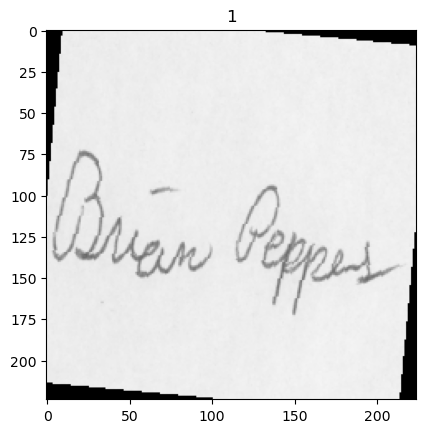

In [70]:
img, label = train_data[0]
show_image(img, label)

In [71]:
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader)))
print("No. of Total examples:{}".format(len(trainloader.dataset)))

validationloader = DataLoader(val_data, batch_size=32, shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader)))
print("No. of Total examples:{}".format(len(validationloader.dataset)))

testloader = DataLoader(test_data, batch_size=32, shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader)))
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:50
No. of Total examples:1584
No. of batches in validationloader:25
No. of Total examples:792
No. of batches in testloader:9
No. of Total examples:264


In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms

In [75]:
model = models.resnet34(pretrained=True)

In [76]:
model.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(model.fc.in_features, len(class_name))
)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [81]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader):

    total_train_loss = 0
    total_test_loss = 0

    model.train()
    with tqdm(train_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description(f'training')
        for images, idxs in pbar:
            images = images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)
            output = model(images)

            loss = criterion(output, idxs)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

    model.eval()
    with tqdm(test_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description(f'testing')
        for images, idxs in pbar:
            images = images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)
            output = model(images)

            loss = criterion(output, idxs)
            total_test_loss += loss.item()

    train_acc = total_train_loss / len(train_data)
    test_acc = total_test_loss / len(val_data)
    print(f'Train loss: {train_acc:.4f} Test loss: {test_acc:.4f} ')
        

In [83]:
%%time
epochs=10
for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")
    train(model, criterion, optimizer, trainloader, validationloader)

Epoch 1/10


Train loss: 0.0005 Test loss: 0.0001 
Epoch 2/10


Train loss: 0.0003 Test loss: 0.0001 
Epoch 3/10


Train loss: 0.0003 Test loss: 0.0000 
Epoch 4/10


Train loss: 0.0003 Test loss: 0.0000 
Epoch 5/10


Train loss: 0.0001 Test loss: 0.0000 
Epoch 6/10


Train loss: 0.0001 Test loss: 0.0001 
Epoch 7/10


Train loss: 0.0002 Test loss: 0.0001 
Epoch 8/10


Train loss: 0.0001 Test loss: 0.0000 
Epoch 9/10


Train loss: 0.0001 Test loss: 0.0000 
Epoch 10/10


Train loss: 0.0001 Test loss: 0.0000 
CPU times: total: 27min 19s
Wall time: 8min 6s


In [88]:
Path = r'C:\\Users\\colew\\Desktop\\WPI\\Classes\\Current\\CS4341\\Projects\\AiSign\\notebook\\model.pt'
torch.save(model, Path)

In [85]:
pwd

'C:\\Users\\colew\\Desktop\\WPI\\Classes\\Current\\CS4341\\Projects\\AiSign\\notebook'

In [90]:
model = torch.load(Path)
model.eval()

C:\Users\colew\AppData\Local\Temp\ipykernel_11068\4183711036.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(Path)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [93]:
def evaluate(model, criterion, optimizer, test_dataloader):
    total_test_loss = 0

    model.eval()
    with tqdm(test_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description(f'testing')
        for images, idxs in pbar:
            images = images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)

            output = model(images)
            loss = criterion(output, idxs)
            total_test_loss += loss.item()

    test_acc = total_test_loss / len(val_data)
    print(f'Test loss: {test_acc:.4f} ')
    

In [94]:
evaluate(model, criterion, optimizer, testloader)

Test loss: 0.0000 


In [95]:
label_names = data.classes
label_names

['Forged', 'Original']

In [100]:
from PIL import Image
image = Image.open(r'C:\Users\colew\Desktop\WPI\Classes\Current\CS4341\Projects\AiSign\notebook\data\Original\original_1_1.png')
preprocess = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor()
])

image = preprocess(image)
image = image[:3]

image = image.unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(image)
    probs = torch.softmax(logits, dim=1)
    pred_label = torch.argmax(probs, dim=1)

print(f'Predicted label: {pred_label.item()}')
predicted_class_name = label_names[pred_label.item()]

print(f'Predicted class name: {predicted_class_name}')

Predicted label: 1
Predicted class name: Original
